## A Halloween treat: what is the best Dracula movie for you to watch?

<img src="https://i.postimg.cc/QdjXBPZd/draculalogosmall.png" alt="dracula logo" width="170"/>

#### _case study of a novel and its numerous movie adaptations, using automatic extraction of sentiments and named entities with spaCy_ 

__Choosing a good movie to watch isn't as simple as finding the movie with the best score or our favorite genre.__
- This is something subjective that depends highly on the watcher, their tastes, their mood and with who they watch it. 
- Movie ratings and tags are great tools to make choices, but cinema is a form of art, and art resonates differently with each individual. 
- This isn't about the _the_ best movie, but the one that will interest _you_ the most.

##### Another problem is spoilers
- There are a lot of handy reviews and summaries, but they often reveal a movie's mysteries. Isn't it more entertaining for the viewer to be the one to discover each plot twist?
- These reviewer's point of view often affects our perception of the movie. You know that feeling when someone points out a minor detail and now you can't unsee it. You don't want this.


#### Our approach
-> using tech to extract two key features: tone and content.

First we will look at the tone of movie. Do you want to see something fun? Serious? Tragic? A rollercoaster of emotions? Automatic sentiment analysis will help us to characterise this.

For the second point, content, you may wonder how we can handle this without spoilers. Well, we will just look at the content, only the  _content_ and not the story. To do this we will used named entity extraction.

#### Some context on this notebook
- This is an entry for the competition _Deepnote + spaCy: NLP in Notebooks_, under the theme _Challenge #2: Analyse sentiment from GoodReads vs IMDB reviews_
- Our focus thus is sentiments in books and movies.
- I wanted to focus on one of the cores of spaCy's uses: natural language processing. To highlight this, I didn't want to use a big corpora, but instead use a small set of texts that we will analyse meticulously.
- I study Art History and French Literature, so that explains why I choose for the latter approach. There is no good or wrong, I just took the path that compels me the most and where my background can add an interesting layer to it.
- For this contest I wanted to show and explain some of my favorite spaCy features. So I'll walk with the reader through the NLP process and will be using an informal writing style to make it more catching.
- Actually, even if this is a notebook / article, I published it with the Deepnote dashboard format, because it offers more options to play with to make a nice layout.
- The techniques showcased here can be used on a larger dataset or to build a Deepnote app. These paths would lead to more findings or better usablity. But at this stage I want to focus on the library's features and educational aspects.
- I really want to explore these other options another time and am looking forward to see how the other participants implemented them :)

### Preparation

This is a more boring part, but it's essential, so I'll write about it and you can chose to read or skip it.

##### Requirements

First you need to make sure that you have everything to make the program work.
You may need to install some stuff. This can be done in the terminal. Here in Deepnote, there is a terminal tab, but we also have a really handy option: a `!` before a line allows it be be executed directly in the notebook.
There is also a `requirements.txt` file, here it makes so that spacytextblob is available. If not, you should do `pip install spacytextblob`.

In [ ]:
!python -m spacy download en_core_web_sm

2022-03-12 10:53:53.256641: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-12 10:53:53.256697: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     |████████████████████████████████| 13.9 MB 17.1 MB/s 
  Using cached typing_extensions-3.10.0.2-py3-none-any.whl (26 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Not uninstalling typing-extensions at /shared-libs/python3.7/py-core/lib/python3.7/site-packages, outside environment /root/venv
    Can't uninstall 'typing-extensions'. No files were found to uninstall.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.l

In [ ]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
import requests
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from spacy import displacy
import csv
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


![](https://www.gutenberg.org/cache/epub/345/pg345.cover.medium.jpg)
<sup>The novel's cover on Project Gutenberg</sup>

First we need to get the novel, we can download the file manually or like this:

In [ ]:
response = requests.get("https://gutenberg.org/files/345/345-0.txt")

if response.status_code == 200:
    response.encoding = 'utf-8'
    contents = response.text
    print(contents[:500])

﻿The Project Gutenberg eBook of Dracula, by Bram Stoker

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this


As you can see we can the novel's text without copyright problems. Lot of thanks to Project Gutenberg!

But these bits of text are not want we want to study. It's called the paratext and here, similarly to metadata, it gives information on the content.

We want only to have the novel's text, the story of Count Dracula. So let's find the start and the end.

In [ ]:
text = contents[contents.find('\r\n\r\n\r\n\r\n\r\nDRACULA\r\n\r\n\r\n\r\n\r\n')
                                : contents.find('THE END')]

__Preprocessing__

We want to make sure the text is usable before analysing it.



Let's split it in chapters

In [ ]:
chapters = text.split('CHAPTER')

In [ ]:
print(chapters[0])






DRACULA







The first item in the chapters list isn't a chapter, but the title, let's remove it.

In [ ]:
chapters.pop(0)

'\r\n\r\n\r\n\r\n\r\nDRACULA\r\n\r\n\r\n\r\n\r\n'

Let's look at the start and end to see how it is there

In [ ]:
print(chapters[0][:50])
print(chapters[1][:50])
print(chapters[-1][:50])

 I

JONATHAN HARKER'S JOURNAL

(_Kept in short
 II

JONATHAN HARKER'S JOURNAL--_continued_


 XXVII

MINA HARKER'S JOURNAL


_1 November._


We don't really want to have the chapter numbers.
Assuming they are always formatted in the same way, we will remove the first line of each chapter.

In [ ]:
chapters = [chap[chap.find('\r\n'):]
            for chap in chapters]

In [ ]:
print(chapters[0][:50])
print(chapters[1][:50])
print(chapters[-1][:50])



JONATHAN HARKER'S JOURNAL

(_Kept in shortha


JONATHAN HARKER'S JOURNAL--_continued_


_5


MINA HARKER'S JOURNAL


_1 November._--All 


Now let's assemble back all the chapters together.

I also decided to remove the underscores that indicate text formatting and the old end of line symbol.
These are replaced with a space to prevent words to be unwantedly glued together.

In [ ]:
text = ''.join([chap.replace('_', ' ')
            .replace('\r\n', ' ')
            for chap in chapters])

In the preprocessing stage I often ask myself which parts of a text could be affect the analyses I want to do.
Capitalisation and punctuation can affect our results. Do we want to treat 'Hello', 'hello', 'hello...' and 'hello!' as meaning the same or as being different.

Functions such as `.lower()`or `.isalnum()` in Python are handy for this.

We won't use them this time because spaCy handle these cases in an intelligent manner. Capitalisation and punctuation are useful to determinate where the sentences are and to communicate sentiments. So we don't want to remove them. 

In [ ]:
print(text[:500])

  JONATHAN HARKER'S JOURNAL  ( Kept in shorthand. )    3 May. Bistritz. --Left Munich at 8:35 P. M., on 1st May, arriving at Vienna early next morning; should have arrived at 6:46, but train was an hour late. Buda-Pesth seems a wonderful place, from the glimpse which I got of it from the train and the little I could walk through the streets. I feared to go very far from the station, as we had arrived late and would start as near the correct time as possible. The impression I had was that we were


spacytextblob allows us to study sentiments, so we have to make sure we have it

In [ ]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'spacytextblob']


In [ ]:
nlp.components

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x7f01dfcb7b40>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7f01dfcb7a60>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x7f01dfa5fd50>),
 ('senter', <spacy.pipeline.senter.SentenceRecognizer at 0x7f01dfcb76e0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7f01df9ede60>),
 ('lemmatizer',
  <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7f01df9f3410>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x7f01dfa5fed0>),
 ('spacytextblob',
  <spacytextblob.spacytextblob.SpacyTextBlob at 0x7f01dffb2050>)]

Now, let's start the main dish.

### DraCuly

We feed the novel's text to the natural language processing pipeline:

In [ ]:
doc_book = nlp(text)

Now we can look at the sentiments!

### Sentiments

In [ ]:
sentence_sentiments = [sentence._.polarity 
                        for sentence 
                        in doc_book.sents]

In [ ]:
sentence_sentiments[:10]

[0.0,
 0.0,
 -0.049999999999999996,
 0.40625,
 -0.017499999999999995,
 0.4833333333333334,
 0.31666666666666665,
 0.0,
 0.10333333333333332,
 0.0]

To have more insight on what these numbers reflect, let's print the corresponding sentences

In [ ]:
sent_dic = list(zip(sentence_sentiments, list(doc_book.sents)))

In [ ]:
sent_dic[:10]

[(0.0,   JONATHAN HARKER'S JOURNAL  ( Kept in shorthand. )),
 (0.0,    3 May. Bistritz.),
 (-0.049999999999999996,
  --Left Munich at 8:35 P. M., on 1st May, arriving at Vienna early next morning; should have arrived at 6:46, but train was an hour late.),
 (0.40625,
  Buda-Pesth seems a wonderful place, from the glimpse which I got of it from the train and the little I could walk through the streets.),
 (-0.017499999999999995,
  I feared to go very far from the station, as we had arrived late and would start as near the correct time as possible.),
 (0.4833333333333334,
  The impression I had was that we were leaving the West and entering the East; the most western of splendid bridges over the Danube, which is here of noble width and depth, took us among the traditions of Turkish rule.),
 (0.31666666666666665,
   We left in pretty good time, and came after nightfall to Klausenburgh.),
 (0.0, Here I stopped for the night at the Hotel Royale.),
 (0.10333333333333332,
  I had for dinner, o

What do you think?

This is what it means:
- Sentences bad sentiments are negative 

In [ ]:
[(sentiment, sentence) for (sentiment, sentence) in sent_dic if sentiment == -1][:10]

[(-1.0, What sort of grim adventure was it on which I had embarked?),
 (-1.0,
  How was it that all the people at Bistritz and on the coach had some terrible fear for me?),
 (-1.0,
  ( Mem. , this diary seems horribly like the beginning of the "Arabian Nights," for everything has to break off at cockcrow--or like the ghost of Hamlet's father.)),
 (-1.0,
  God knows that there is ground for my terrible fear in this accursed place!),
 (-1.0,
   I was awakened by the Count, who looked at me as grimly as a man can look as he said:--  "To-morrow, my friend, we must part.),
 (-1.0,  I am alone in the castle with those awful women.),
 (-1.0, I may find a way from this dreadful place.),
 (-1.0, Isn't it awful!),
 (-1.0, This suspense is getting dreadful.),
 (-1.0,
  The wind had by this time backed to the east, and there was a shudder amongst the watchers on the cliff as they realized the terrible danger in which she now was.)]

- and more happy sentences get a positive score

In [ ]:
[(sentiment, sentence) for (sentiment, sentence) in sent_dic if sentiment == 1][:10]

[(1.0,
  I was told that this road is in summertime excellent, but that it had not yet been put in order after the winter snows.),
 (1.0,  "Indeed," I said, "you speak excellently."),
 (1.0,
  The view was magnificent, and from where I stood there was every opportunity of seeing it.),
 (1.0, Great God!),
 (1.0, I can fancy what a wonderful power he must have over his patients.),
 (1.0,
  I am very, very happy, and I don't know what I have done to deserve it.),
 (1.0, Happy thought!),
 (1.0,
   "We are the best nurses, you and I. You keep watch all night; see that she is well fed, and that nothing disturbs her.),
 (1.0,
  When I told Mrs. Westenra that Dr. Van Helsing had directed that I should sit up with her she almost pooh-poohed the idea, pointing out her daughter's renewed strength and excellent spirits.),
 (1.0, Our evening was a very, very happy one.)]

-1 and 1 are the most extreme sentiments, but there is everything in between too.

0.0 scores however often are sentences that are neutral or where the sentiment is unclear. These are less interesting for our analysis, so we will keep them out.

In [ ]:
sentence_sentiments = [sentiment 
                        for sentiment 
                        in sentence_sentiments
                        if sentiment != 0]

In [ ]:
sentence_sentiments[:10]

[-0.049999999999999996,
 0.40625,
 -0.017499999999999995,
 0.4833333333333334,
 0.31666666666666665,
 0.10333333333333332,
 0.5,
 0.2966666666666667,
 -0.25,
 -0.2125]

Let's see what it looks like:

In [ ]:
def plot_sentiments_average(sent_list, parts, title, color = 'black'):
    plt.figure(figsize=(20, 5))

    #make groups of sentences
    parts = int(len(sent_list) / parts) #length in elements of each part
    temp = [sent_list[i:i + parts] \
            for i in range(0, len(sent_list), parts)]
    
    #make an average for each part
    temp = [sum(part) / len(part) for part in temp]
    
    plt.plot(temp, color)
    plt.title(f'Sentiments in {title}', size = 25)
    plt.ylabel('Negative             -             Positive')
    
    # remove tick labels as they don't mean much here
    plt.tick_params(labelleft=False, labelbottom=False)

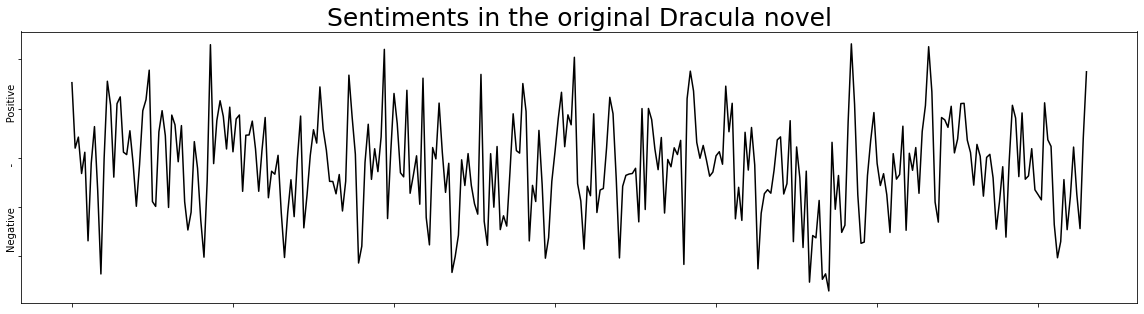

In [ ]:
plot_sentiments_average(sentence_sentiments, 300, 'the original Dracula novel')

There are a lot of ups and downs in the story.

Around one third of the story things get really bad.

This is typical for the final act, where the protagonists must overcome a difficult challenge.

After that things get better.

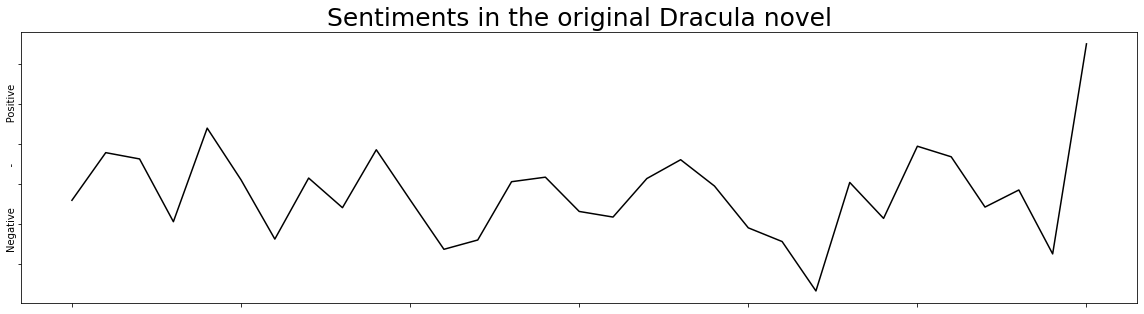

In [ ]:
plot_sentiments_average(sentence_sentiments, 30, 'the original Dracula novel')

What we saw just now is the text in the original Dracula novel.

Let's apply the same technique on a description from Wikipedia of the novel:

In [ ]:
book_plot_wiki = """Jonathan Harker, a newly qualified English solicitor, visits Count Dracula at his castle in the Carpathian Mountains to help the Count purchase a house near London. Ignoring the Count's warning, Harker wanders the castle and encounters three vampire women; Dracula rescues Harker, and gives the women a small child bound inside a bag. Harker awakens in bed; soon after, Dracula leaves the castle, abandoning him to the women; Harker escapes with his life and ends up delirious in a Budapest hospital. Dracula takes a ship for England with boxes of earth from his castle. The captain's log narrates the crew's disappearance until he alone remains, bound to the helm to maintain course. An animal resembling a large dog is seen leaping ashore when the ship runs aground at Whitby.
Lucy Westenra's letter to her best friend, Harker's fiancée Mina Murray, describes her marriage proposals from Dr. John Seward, Quincey Morris, and Arthur Holmwood. Lucy accepts Holmwood's, but all remain friends. Mina joins her friend Lucy on holiday in Whitby. Lucy begins sleepwalking. After his ship lands there, Dracula stalks Lucy. Mina receives a letter about her missing fiancé's illness, and goes to Budapest to nurse him. Lucy becomes very ill. Seward's old teacher, Professor Abraham Van Helsing, determines the nature of Lucy's condition, but refuses to disclose it. He diagnoses her with acute blood-loss. Van Helsing places garlic flowers around her room and makes her a necklace of them. Lucy's mother removes the garlic flowers, not knowing they repel vampires. While Seward and Van Helsing are absent, Lucy and her mother are terrified by a wolf and Mrs. Westenra dies of a heart attack; Lucy dies shortly thereafter. After her burial, newspapers report children being stalked in the night by a "bloofer lady" (beautiful lady), and Van Helsing deduces it is Lucy. The four go to her tomb and see that she is a vampire. They stake her heart, behead her, and fill her mouth with garlic. Jonathan Harker and his now-wife Mina have returned, and they join the campaign against Dracula.
Everyone stays at Dr. Seward's asylum as the men begin to hunt Dracula. Van Helsing finally reveals that vampires can only rest on earth from their homeland. Dracula communicates with Seward's patient, Renfield, an insane man who eats vermin to absorb their life force. After Dracula learns of the group's plot against him, he uses Renfield to enter the asylum. He secretly attacks Mina three times, drinking her blood each time and forcing Mina to drink his blood on the final visit. She is cursed to become a vampire after her death unless Dracula is killed. As the men find Dracula's properties, they discover many earth boxes within. The vampire hunters open each of the boxes and seal wafers of sacramental bread inside them, rendering them useless to Dracula. They attempt to trap the Count in his Piccadilly house, but he escapes. They learn that Dracula is fleeing to his castle in Transylvania with his last box. Mina has a faint psychic connection to Dracula, which Van Helsing exploits via hypnosis to track Dracula's movements. Guided by Mina, they pursue him.
In Galatz, Romania, the hunters split up. Van Helsing and Mina go to Dracula's castle, where the professor destroys the vampire women. Jonathan Harker and Arthur Holmwood follow Dracula's boat on the river, while Quincey Morris and John Seward parallel them on land. After Dracula's box is finally loaded onto a wagon by Szgany men, the hunters converge and attack it. After routing the Szgany, Harker slashes Dracula's neck and Quincey stabs him in the heart. Dracula crumbles to dust, freeing Mina from her vampiric curse. Quincey is mortally wounded in the fight against the Szgany. He dies from his wounds, at peace with the knowledge that Mina is saved. A note by Jonathan Harker seven years later states that the Harkers have a son, named Quincey."""

In [ ]:
doc_book_plot = nlp(book_plot_wiki)

We will use this again later on, so I made a function for it:

In [ ]:
def calc_sentence_sentiments(doc):
    #retrieve sentiment scores
    temp = [sentence._.polarity for sentence in doc.sents]

    # remove null values
    temp = [sentiment for sentiment in temp if sentiment != 0]

    return temp

In [ ]:
wiki_sentiments = calc_sentence_sentiments(doc_book_plot)

The summary is really short compared to the novel, which is actually the point for a summary.

Here are all the sentiments extracted from it:

In [ ]:
wiki_sentiments

[0.07878787878787878,
 -0.25,
 0.21428571428571427,
 1.0,
 -0.2,
 -0.65,
 0.1,
 0.6,
 0.85,
 -1.0,
 -0.2,
 -0.2,
 0.5,
 -0.25,
 -0.5]

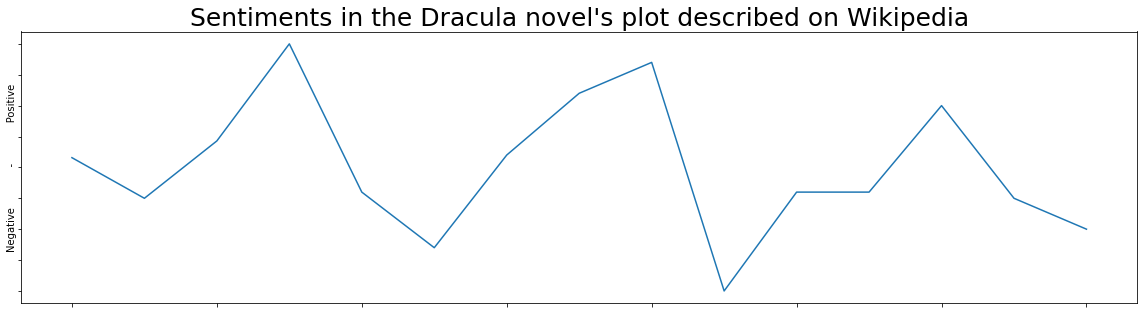

In [ ]:
plt.figure(figsize=(20, 5))

plt.plot(wiki_sentiments)
plt.title("Sentiments in the Dracula novel's plot described on Wikipedia", size = 25)
plt.ylabel('Negative             -             Positive')

# remove tick labels as they don't mean much here
plt.tick_params(labelleft=False, labelbottom=False)

We can see a big dip around on third of the story again.

Because the style of writing in a summary differs a lot from the novel, we can't really use these sentiments to make precise conclusions, but they still give an overall idea.

The end described on the Wikipedia page of the novel looks to have a more negative tone.

We can compute the average mood of the texts. Here are the sentiment scores of the origial Dracula novel and the Wikipedia plot summary. But due to the texts being different formats we can't really interpret these.

In [ ]:
doc_book._.polarity 

0.07495122086295743

In [ ]:
doc_book_plot._.polarity 

-0.00766733266733266

### Named entites recognition

spaCy can detect extract information from texts. This pipeline can be trained for specific goals, but the default one is sufficient for today.

Here is what it looks like:

In [ ]:
displacy.render(doc_book[:200], style='ent', jupyter='True')

These entities are classified in different types of information.

We can filter for a specific type, such as characters, with the entity label `PERSON`:

In [ ]:
characters_wiki = [ent.text for ent in doc_book_plot.ents if ent.label_ == 'PERSON']
characters_book = [ent.text for ent in doc_book.ents if ent.label_ == 'PERSON']

To compare the two texts, let's look at the most frequent person entities:

In [ ]:
#novel's text
Counter(characters_book).most_common(15)

[('Lucy', 271),
 ('Van Helsing', 200),
 ('Jonathan', 117),
 ('Harker', 104),
 ('Arthur', 96),
 ('Seward', 94),
 ('Mina', 67),
 ('Quincey', 54),
 ('Morris', 47),
 ('Renfield', 46),
 ('John', 29),
 ('Quincey Morris', 21),
 ('Madam Mina', 20),
 ('Westenra', 19),
 ('Hawkins', 18)]

In [ ]:
#plot on Wiki
Counter(characters_wiki).most_common(15)

[('Dracula', 19),
 ('Lucy', 10),
 ('Harker', 6),
 ('Mina', 6),
 ('Jonathan Harker', 4),
 ('Quincey', 3),
 ('John Seward', 2),
 ('Quincey Morris', 2),
 ('Arthur Holmwood', 2),
 ('Van Helsing', 2),
 ('Renfield', 2),
 ('Count Dracula', 1),
 ('Lucy Westenra', 1),
 ('Mina Murray', 1),
 ('Holmwood', 1)]

It is interesting to see that Wikipedia gives more attention to Dracula than in the book.
This could also be because in the original text, Darcula is referenced in an indirect manner.
This is something we can't know right now, or only if we start reading.

A cool thing we can do also is set theory!

We can look if in the summary there are characters that aren't in the book

In [ ]:
print(set(characters_wiki) - set(characters_book))

set()


The resulting set is empty, it is quite obvious because else the summary is incorrect.

This would happen if it wasn't the case:

In [ ]:
print(set(characters_wiki + ['another character']) - set(characters_book))

{'another character'}


My favorite entity type is `WORK_OF_ART` which returns titles of books, artworks and objects.

 <sup>(I'm really biased because I study art and literature haha)</sup>

This entity isn't used showed really often in spaCy tutorials, probably because it is less useful than the others, but I wanted to shine some light on it.

It doesn't help the results aren't really accurate, it has some confusion with characters and speech expressions.

Mina seems to have artsy vibes in spaCy's eyes.

But these misclassifications are really interesting and fun.

They could be works of art, and some of them could be metal album names or horror movie titles!

<sup>note: I made a set to remove duplicates and order the strings</sup>



In [ ]:
set([ent.text for ent
in doc_book.ents
if ent.label_ == 'WORK_OF_ART'])

{'"Count Dracula',
 '"Dear Madam,--  ',
 '"Lord Godalming',
 '"The English Herr',
 '"The Host',
 '"The Pall Mall Gazette',
 '"The Szgany',
 '"The Westminster Gazette',
 '"We Szekelys',
 '"Westminster Gazette',
 '4 May. --I',
 'ARTHUR',
 'Amen',
 'At Purfleet',
 'Bersicker',
 'Blue',
 'Charcot',
 'DRACULA',
 'Dame Nature',
 'Dear Madam Mina,--',
 'Dear Madam,--  ',
 'Dear Sirs,--  ',
 'Diary    Hillingham',
 'Evening',
 'Fear for  ',
 'Finis',
 'For Sale',
 'Fortune',
 'Hamlet',
 'Hush',
 "Jack Straw's",
 'Kukri',
 'Lenore":--      "Denn die Todten',
 'Lord----',
 'Love',
 'MINA HARKER',
 'Madam Mina',
 'Midnight',
 'Mina',
 'Mina and Seward',
 'Mittel Land',
 'New Woman',
 'New Women',
 'Pall Mall Gazette',
 'QUINCEY P. MORRIS',
 'Quick, Doctor, quick',
 'THE ESCAPED WOLF',
 'The  Acherontia Aitetropos of the Sphinges',
 'The  Czarina Catherine  ',
 'The Count is a criminal',
 'The Dailygraph',
 'The Exeter News',
 'The Kensington Horror',
 'The Pall Mall Gazette',
 'The Stabbing Woman

Times are also interesting to extract, looking quickly at them we can see that the story happens mostly at night!

In [ ]:
print([ent.text for ent
in doc_book.ents
if (ent.label_ == 'TIME')])

['early next morning', 'an hour', 'the night', 'all night', 'forcemeat', 'a little before eight', '7:30', 'more than an hour', 'midnight', 'afternoon', 'evening', 'earlier in the evening', 'An hour', 'early to-night', 'night', 'a few minutes of midnight', 'a few minutes', 'the morning', 'the afternoon', 'early morning', 'a good night', 'last night', 'last night', 'one night', 'an hour', 'the previous night', 'the last evening', 'hour after hour', 'a few hours', 'Good-morning', 'a few hours', 'morning', 'Last evening', 'this evening', 'Last night', 'the next morning', 'a minute', 'A minute later', 'an hour or', '--This morning', 'before morning', 'a couple of hours', 'morning', 'the night', 'this morning', 'Last night', 'a few hours', 'morning', 'morning', 'a minute or', 'morning', "ten o'clock", 'Good-night', 'an hour ago', 'night', 'a few moments', 'Last night', "a few minutes'", 'evening', 'the afternoon', 'midnight', 'A little after midnight', 'a very few minutes', 'last night', 'th

We can look at the other entities in the summary to have some insights on the content of the story.

<sup>(Mina is quite onmipresent, she's a location here too)</sup>

In [ ]:
for ent in doc_book_plot.ents:
    if ent.label_ != 'PERSON' and ent.label_ != 'CARDINAL':
        print(ent.text, ent.label_)

English NORP
the Carpathian Mountains EVENT
Count ORG
London GPE
Count ORG
Budapest GPE
England GPE
Whitby ORG
Budapest GPE
Van Helsing ORG
Seward ORG
Mina ORG
Transylvania GPE
Van Helsing ORG
Galatz GPE
Romania GPE
Szgany LOC
Szgany LOC
seven years later DATE
Harkers ORG


Okay, this is interesting, but we are not here to have a literature class on Bram Stoker's oeuvre.
We want to find a good Halloween movie.


### Movie adaptations



Screenplays are most of the time under copyright, so we will forget this, I am not a Law student.

Movie descriptions are made to sell and don't tell everything, so this isn't the best.

Luckily we have another option to get a glimpse in the content of a movie: Wikipedia~~!

##### Dataset

JustinR, _Wikipedia Movie Plots (Plot descriptions for ~35,000 movies)_, 2018:
www.kaggle.com/jrobischon/wikipedia-movie-plots

```sql
SELECT * FROM plots
WHERE Title LIKE '%Dracula%'
```

The dataset has a lot of movies. Using SQLite I filtered out movies with the word Dracula in the titles, and saved them in a CSV file which I uploaded here.

There are a lot of movies that take inspiration from the Dracula legend and vampire myths. This is only a selection of them and I won't dig too deep today. But I still had to do something: add the _Nosferatu_ (1922) movie, the first 'adaptation' of the novel, where the names were changed due to copyrigth. We can't miss on this classic.

I also did minor some changes, such as replacing the plot of _The Return of Dracula_ with the correct one or removing the Bollywood version by Bhooshan Lal as this one sadly doesn't have a plot description on wiki (the plot of the book has used instead, even if there's overlap it isn't the description of the movie). It's always important to check your data for errors!

In [ ]:


df_1 = _deepnote_execute_sql("""SELECT *, LEN(Plot)
FROM '/work/dracula_nosferatu_plots.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_1

,ReleaseYear,Title,Origin/Ethnicity,Director,Cast,Genre,WikiPage,Plot,len(plot)
0,1931,Dracula,American,Tod Browning,"Bela Lugosi, Helen Chandler, David Manners",horror,https://en.wikipedia.org/wiki/Dracula_(1931_En...,Renfield (Dwight Frye) is a solicitor travelin...,4430
1,1936,Dracula's Daughter,American,Lambert Hillyer,"Otto Kruger, Gloria Holden, John Carradine",horror,https://en.wikipedia.org/wiki/Dracula%27s_Daug...,Dracula's Daughter begins a few moments after ...,2430
2,1943,Son of Dracula,American,Robert Siodmak,"Lon Chaney, Jr., Evelyn Ankers",horror,https://en.wikipedia.org/wiki/Son_of_Dracula_(...,"Hungarian Count Alucard (Lon Chaney Jr.), a my...",2810
3,1945,House of Dracula,American,Erle C. Kenton,"Lon Chaney, John Carradine, Onslow Stevens Mar...",horror,https://en.wikipedia.org/wiki/House_of_Dracula,Count Dracula (Carradine) arrives at the castl...,4455
4,1958,The Return of Dracula,American,Paul Landres,"Francis Lederer, Norma Eberhardt",horror,https://en.wikipedia.org/wiki/The_Return_of_Dr...,"In Central Europe, Investigator John Meierman ...",4074
5,1966,Billy the Kid vs. Dracula,American,William Beaudine,"John Carradine, Chuck Courtney","western, horror",https://en.wikipedia.org/wiki/Billy_the_Kid_vs...,The film centers on Dracula's plot to convert ...,1092
6,1969,Blood of Dracula's Castle,American,Al Adamson,"John Carradine, Robert Dix",horror,https://en.wikipedia.org/wiki/Blood_of_Dracula...,Count Dracula (Alexander D'Arcy) and his vampi...,832
7,1971,Dracula vs. Frankenstein,American,Al Adamson,"Lon Chaney, Jr., J. Carrol Naish",horror,https://en.wikipedia.org/wiki/Dracula_vs._Fran...,Wheelchair-bound mad scientist Dr. Durea (J. C...,3821
8,1979,Dracula,American,John Badham,"Frank Langella, Laurence Olivier",horror,https://en.wikipedia.org/wiki/Dracula_(1979_film),"In Whitby, England in 1913, Count Dracula (Fra...",3643
9,1992,Bram Stoker's Dracula,American,Francis Ford Coppola,"Gary Oldman, Winona Ryder, Keanu Reeves, Antho...",horror,https://en.wikipedia.org/wiki/Bram_Stoker%27s_...,"In 1462, Vlad Dracula, a member of the Order o...",4475


Deepnote allows us to explore the data in an interactive way. If you want you want, there are features to visualize it too.

We can see that Dracula movies aren't always Horror movie: the genre can be Fantasy, Western and Dance too.

Terence Fisher directed the most of Dracula movies.

It is also important to note that the length of the plot description varies. The shortest being around 800 characters and the longuest almost 7000.

In [ ]:
with open('/work/dracula_nosferatu_plots.csv', newline='') as f:
    reader = csv.reader(f)
    movie_plots = list(reader)

For my own convenience I choose to use a nested lists format for the CSV file, but you can ude Pandas dataframes or SQL integrations too. These allow for extra features on Deepnote.

In [ ]:
print(movie_plots[0])

['ReleaseYear', 'Title', 'Origin/Ethnicity', 'Director', 'Cast', 'Genre', 'WikiPage', 'Plot']


As there are a lot of movies, I made a class for them

In [ ]:
class movie:
    instances = []

    def __init__(self, item, varname):
        self.name = varname
        self.release_year = item[0]
        self.title = item[1]
        self.plot = item[-1]
        self.__class__.instances.append(self)

    def spacy_magic(self):
        self.nlp = nlp(self.plot)


In [ ]:
Counter([film[0] for film in movie_plots]).most_common(5)

[('1971', 3), ('1958', 2), ('1966', 2), ('1969', 2), ('ReleaseYear', 1)]

In [ ]:
Counter([film[1] for film in movie_plots]).most_common(5)

[('Dracula', 3),
 ('Title', 1),
 ("Dracula's Daughter", 1),
 ('Son of Dracula', 1),
 ('House of Dracula', 1)]

I want each to have a distinct variable name, so I will use a combination of the release year and three first letters of the title

In [ ]:
for film in movie_plots[1:]:
    #make name
    varname = film[0] + film[1][:3]

    #make movie object
    globals()[varname] = movie(film, varname)

In [ ]:
for film in movie.instances:
    print(film.name, end = ' ')

1931Dra 1936Dra 1943Son 1945Hou 1958The 1966Bil 1969Blo 1971Dra 1979Dra 1992Bra 1995Dra 2000Dra 2012Dra 2013Dra 2014Dra 1958Dra 1960The 1966Dra 1968Dra 1969Tas 1970Sca 1971Cou 1972Dra 1974The 2002Dra 1971Lak 1922Nos 

Let's put their plot through the NLP pipeline

In [ ]:
for film in movie.instances:
    film.spacy_magic()

We can now look at characters that are in the movies but not in the original book:

In [ ]:
for film in movie.instances:
    print('\n', film.title, film.release_year, 'new characters:')
    characters_wiki = [ent.text for ent in film.nlp.ents if ent.label_ == 'PERSON']
    print(set(characters_wiki) - set(characters_book))


 Dracula 1931 new characters:
{'Helen Chandler', 'Dwight Frye', 'John Harker', 'Lucy Weston', 'Dracula with Mina', 'Carfax Abbey', 'Joan Standing', 'Edward Van Sloan', 'Briggs', 'Herbert Bunston', 'Bela Lugosi', 'Nurse Briggs', "Count Dracula's", 'David Manners'}

 Dracula's Daughter 1936 new characters:
{'Irving Pichel', 'Otto Kruger', 'Countess Zaleska', 'Countess', 'Gloria Holden', 'Von Helsing', 'Countess Marya', 'Sandor', 'Janet', 'Edward Van Sloan', 'Garth', 'Lili (Nan Grey', 'Jeffrey Garth'}

 Son of Dracula 1943 new characters:
{'Katherine Caldwell', 'Brewster', 'Katherine', 'George Irving', 'Claire', 'Frank', 'Alucard', 'Louise Allbritton', 'Frank Stanley', 'Caldwell'}

 House of Dracula 1945 new characters:
{'Niemann', 'Onslow Stevens', "Martha O'Driscoll", 'Latos', 'Lawrence Talbot', 'Frankenstein', 'Steinmuhl', 'Skelton Knaggs', 'Franz Edlemann', 'Lionel Atwill', 'Holtz', 'Jane Adams', 'Talbot', 'Edlemann'}

 The Return of Dracula 1958 new characters:
{'Jennie', 'Whitfield

Some have a totally different cast of characters!

_Dracula: Pages from a Virgin's Diary_ seem to be the least different in terms of characters. The new names that spaCy found are due to different spellings (Jonathon or Jonathan, a 'Soon' or ''s' that shouldn't be there).

We can also look where the stories take place:

In [ ]:
for film in movie.instances:
    print('\n', film.title, film.release_year, 'focus:')
    focus = [ent.text for ent in film.nlp.ents if (ent.label_ in ('GPE', 'FAC', 'ORG'))]
    print(set(focus))


 Dracula 1931 focus:
{'Mina', 'Van Helsing', 'England', 'Harker', 'Vesta', 'Transylvania', 'London'}

 Dracula's Daughter 1936 focus:
{'Scotland Yard', 'Countess', 'Castle Dracula', 'Zaleska', 'Transylvania', 'London'}

 Son of Dracula 1943 focus:
{'Brewster', 'Count', 'Katherine', 'Dark Oaks', 'U.S.', 'New Orleans', 'Alucard', 'Sheriff'}

 House of Dracula 1945 focus:
{'Visaria', 'Count', 'Wolfman', 'Nina', 'Edlemann', 'Milizia', 'Talbot'}

 The Return of Dracula 1958 focus:
{'Jennie', 'Carleton', 'Germany', 'Rachel', 'the United States', 'Mickey', 'Bellac', 'California'}

 Billy the Kid vs. Dracula 1966 focus:
{'Count', 'Bentley', 'Betty'}

 Blood of Dracula's Castle 1969 focus:
{'Count and Countess Townsend', 'California', "Shea's Castle", 'Arizona', 'Bloody Marys', 'Lancaster'}

 Dracula vs. Frankenstein 1971 focus:
{'Judith', 'Jr.', 'Emporium', 'Lon Chaney', 'Las Vegas', 'Durea', 'Venice', 'Samantha', 'Martin', 'the Creature Emporium', 'California'}

 Dracula 1979 focus:
{'Count'

Or the overall tone of the plots

In [ ]:
for film in movie.instances:
    print('\n', film.title, film.release_year, 'average plot mood: ', round(film.nlp._.polarity, 2))


 Dracula 1931 average plot mood:  0.02

 Dracula's Daughter 1936 average plot mood:  -0.04

 Son of Dracula 1943 average plot mood:  -0.01

 House of Dracula 1945 average plot mood:  -0.1

 The Return of Dracula 1958 average plot mood:  -0.1

 Billy the Kid vs. Dracula 1966 average plot mood:  0.34

 Blood of Dracula's Castle 1969 average plot mood:  -0.05

 Dracula vs. Frankenstein 1971 average plot mood:  0.1

 Dracula 1979 average plot mood:  0.0

 Bram Stoker's Dracula 1992 average plot mood:  -0.09

 Dracula: Dead and Loving It 1995 average plot mood:  -0.0

 Dracula 2000 2000 average plot mood:  -0.03

 Dracula Reborn 2012 average plot mood:  0.04

 Dracula: The Dark Prince 2013 average plot mood:  0.03

 Dracula Untold 2014 average plot mood:  0.07

 Dracula 1958 average plot mood:  -0.02

 The Brides of Dracula 1960 average plot mood:  -0.01

 Dracula: Prince of Darkness 1966 average plot mood:  0.03

 Dracula Has Risen from the Grave 1968 average plot mood:  0.06

 Taste the 

We can order them:

In [ ]:
titles = []
ids = []
moods = []

for film in movie.instances:
    titles.append(film.title)
    ids.append(film.name)
    moods.append(film.nlp._.polarity)

df_sentiments = pd.DataFrame(data = {'id' : ids, 'title' : titles, 'mood' : moods})

In [ ]:
df_sentiments.sort_values(by='mood')

,id,title,mood
3,1945Hou,House of Dracula,-0.098897
22,1972Dra,Dracula AD 1972,-0.098351
4,1958The,The Return of Dracula,-0.095653
9,1992Bra,Bram Stoker's Dracula,-0.094641
19,1969Tas,Taste the Blood of Dracula,-0.077209
6,1969Blo,Blood of Dracula's Castle,-0.052500
1,1936Dra,Dracula's Daughter,-0.038095
11,2000Dra,Dracula 2000,-0.033275
23,1974The,The Satanic Rites of Dracula,-0.020833
25,1971Lak,Lake of Dracula,-0.019658


Even if it is a horror movie, _Billy the Kid vs. Dracula_ seems to be the most positive one

We can also look at how the mood changes through the movies:

In [ ]:
def plot_sentiments(film):
    sentiments = [sent._.polarity for sent in film.nlp.sents if sent._.polarity != 0]
    plt.figure(figsize=(10, 0.5))

    plt.plot(sentiments)
    plt.title(f'Sentiments in {film.title} ({film.release_year})', size = 15)

    # remove tick labels as they don't mean much here
    plt.tick_params(labelleft=False, labelbottom=False)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


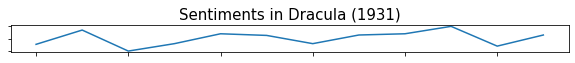

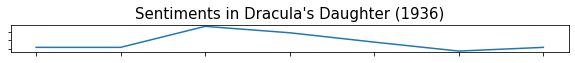

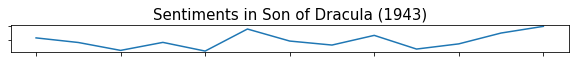

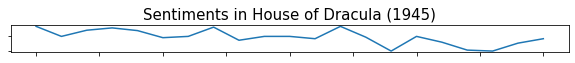

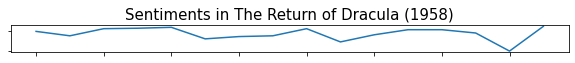

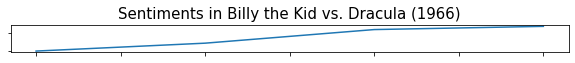

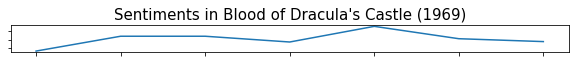

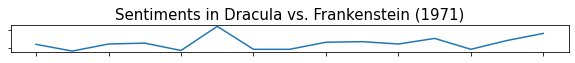

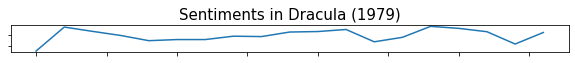

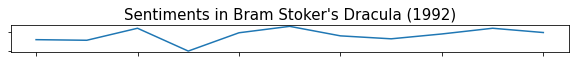

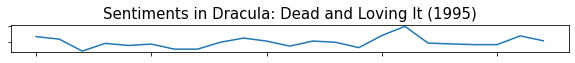

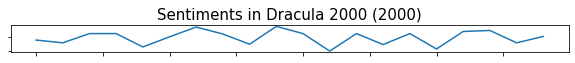

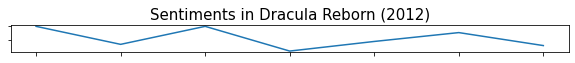

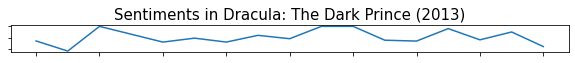

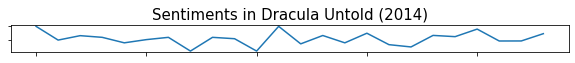

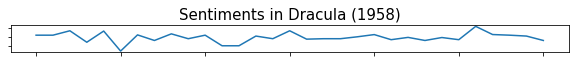

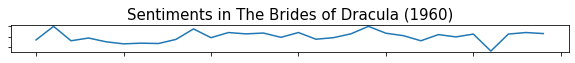

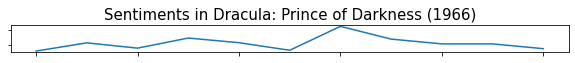

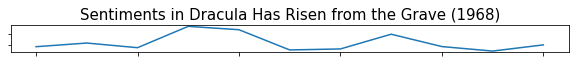

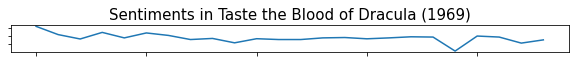

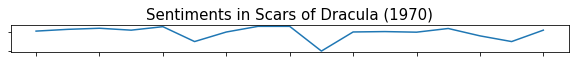

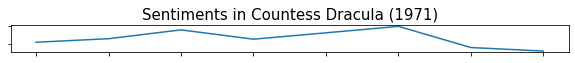

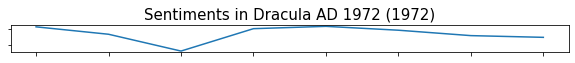

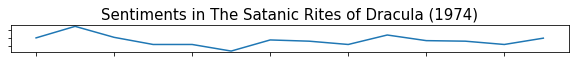

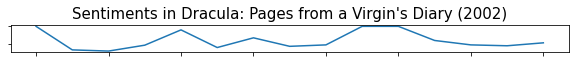

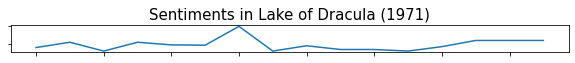

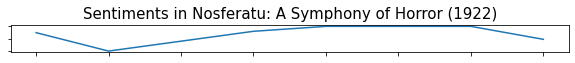

In [ ]:
for film in movie.instances:
    plot_sentiments(film)

In [ ]:
def display_only_entities(doc, types):
    previous = [] # to look for duplicates

    for ent in doc.nlp.ents:
        if (ent.text in previous) == False:
            if ent.label_ in types:
                displacy.render(ent, style='ent', jupyter='True')
                previous.append(ent.text)

With some widgets we can browse the content of the movies in a more fluid way, and without revealing the plot!

In [ ]:
len(movie.instances)

27

In [ ]:
movienum = 15

In [ ]:
focus = 'Universe'

In [ ]:
df_1.iloc[movienum - 1]

ReleaseYear                                                      2014
Title                                                  Dracula Untold
Origin/Ethnicity                                             American
Director                                                   Gary Shore
Cast                Luke Evans\nSarah Gadon\nDominic Cooper\nZach ...
Genre                                                         fantasy
WikiPage                 https://en.wikipedia.org/wiki/Dracula_Untold
Plot                Before the Renaissance, Vlad Țepeș is the Prin...
len(plot)                                                        4597
Name: 14, dtype: object

In [ ]:
ent_types = set()
if focus == 'Universe':
    ent_types = ('ORG', 'PRODUCT', 'GPE', 'FAC', 'LOC', 'EVENT', 'LANGUAGE' , 'NORP')
if focus == 'Characters':
    ent_types = ('PERSON')
if focus == 'Time':
    ent_types = ('TIME', 'DATE')

display_only_entities(movie.instances[movienum - 1], ent_types)

   * If you get an error message, got to `view source` and run the code there 

### Conclusion
Now you have some insights in each movie. Your turn to make a choice.

What does pick your interest? The cast of new characters? The similarity to the original novel? A hectic or fun ride in sentiments? The universe where the story takes place? A victorian or modern setting?

### To explore further
- How different are the movies from another?
- Can we identify specific topics?
- What do reviewers think of the movies?

#### More details on the NLP techniques:

SpacyTextBlob, https://spacytextblob.netlify.app/

Named Entities, https://spacy.io/usage/linguistic-features#named-entities

On plots and sentiments:
https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/04-Sentiment-Analysis.html#calculate-sentiment-scores-for-little-red-riding-hood

https://www.theparisreview.org/blog/2015/02/04/man-in-hole/

https://observablehq.com/@bmschmidt/book-visualizations-sandbox

On reviews:

https://post45.org/2021/04/the-goodreads-classics-a-computational-study-of-readers-amazon-and-crowdsourced-amateur-criticism/


### Small extra's for you

In [ ]:
family = []
for film in movie.instances:
    family = family + [ent.text for ent in film.nlp.ents 
    if ent.label_ == 'PERSON' and 'helsing' in ent.text.lower()
    and len(ent.text.split(' ')) >= 3]

print(*set(family), sep='\n')

Lorrimer Van Helsing
Jessica Van Helsing
Abraham Van Helsing
Matthew Van Helsing
Leonardo Van Helsing


The Helsing family is present in a lot of Dracula movies!

I uploaded in the files of this notebook a CSV with Dracula movie reviews that you can analyse with the NLP techniques we saw today.

(source dataset: Stefano Leone, www.kaggle.com/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset, 2020)

``` SQL
SELECT rotten_tomatoes_link, review_content
FROM rotten_tomatoes_critic_reviews
WHERE rotten_tomatoes_link IN (
	SELECT rotten_tomatoes_link
        FROM rotten_tomatoes_movies
	WHERE movie_title LIKE '%Dracula%'
	OR movie_title LIKE '%Nosferatu%')
```

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=21aefc33-bbed-4601-b541-717690ca50e5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>